In [1]:
using Pkg
Pkg.activate(".")

using PythonCall,CondaPkg
JEft=pyimport("justetf_scraping")

using CairoMakie
using Serialization, CSV, DataFrames, Dates
using Statistics, CovarianceEstimation, Random
using LinearAlgebra 
using NLopt

include("src/src.jl")

  Activating project at `~/Codes/portfolio`
    CondaPkg Found dependencies: /home/nikolay/Codes/portfolio/CondaPkg.toml
    CondaPkg Found dependencies: /home/nikolay/.julia/packages/PythonCall/Nr75f/CondaPkg.toml
    CondaPkg Dependencies already up to date


get_R_RR_cor (generic function with 1 method)

In [3]:
portfolio=deserialize("Sharpe&Entropy 1")
w_opt=portfolio["optimal_portfolio"]
DO=portfolio["overview_table"];
DC=up_to_date_charts(DO,"tmp.csv");
R,RR,cor=get_R_RR_cor(DC, 365, 4);

DE000A0S9GB0 is loaded 1/12
IE00B3WJKG14 is loaded 2/12
IE00BZ1NCS44 is loaded 3/12
IE00BWBXM492 is loaded 4/12
IE00B40B8R38 is loaded 5/12
IE00B3WMTH43 is loaded 6/12
IE00BF0M2Z96 is loaded 7/12
IE00BDFJYM28 is loaded 8/12
LU1390062245 is loaded 9/12
LU1900067601 is loaded 10/12
LU0832435464 is loaded 11/12
IE00BYQCZD50 is loaded 12/12


In [11]:
ret=dot(R,w_opt)
risk=sqrt(dot(w_opt,RR*w_opt))
ret_risk_r=dot(R,w_opt)/sqrt(dot(w_opt,RR*w_opt))

println("""
return             :   $ret
risk               :   $risk
return risk ratio  :   $ret_risk_r
==================================
Portfolio content:
""")


p=sortperm(w_opt; rev=true)
names_ordered=DO.name[p]
isin_ordered=DO.isin[p]
w_opt_ord=w_opt[p]
for i=1:length(w_opt_ord)
    println(names_ordered[i]," : ", isin_ordered[i], " | ", round(w_opt_ord[i]; digits=3))
end

return             :   0.13140438557446357
risk               :   0.05034762424751627
return risk ratio  :   2.609942128122281
Portfolio content:

Xetra-Gold : DE000A0S9GB0 | 0.253
iShares S&P 500 Information Technology Sector UCITS ETF USD (Acc) : IE00B3WJKG14 | 0.198
Amundi MSCI Turkey UCITS ETF Acc : LU1900067601 | 0.123
WisdomTree Japan Equity UCITS ETF USD Hedged Acc : IE00BYQCZD50 | 0.1
L&G Battery Value-Chain UCITS ETF : IE00BF0M2Z96 | 0.076
Amundi Euro Inflation Expectations 2-10Y UCITS ETF Acc : LU1390062245 | 0.071
Invesco US Health Care Sector UCITS ETF : IE00B3WMTH43 | 0.048
iShares Bloomberg Roll Select Commodity Swap UCITS ETF USD : IE00BZ1NCS44 | 0.046
Amundi S&P 500 VIX Futures Enhanced Roll UCITS ETF Acc : LU0832435464 | 0.042
SPDR S&P US Energy Select Sector UCITS ETF : IE00BWBXM492 | 0.017
iShares S&P 500 Consumer Staples Sector UCITS ETF : IE00B40B8R38 | 0.015
iShares US Aggregate Bond UCITS ETF EUR Hedged (Acc) : IE00BDFJYM28 | 0.01


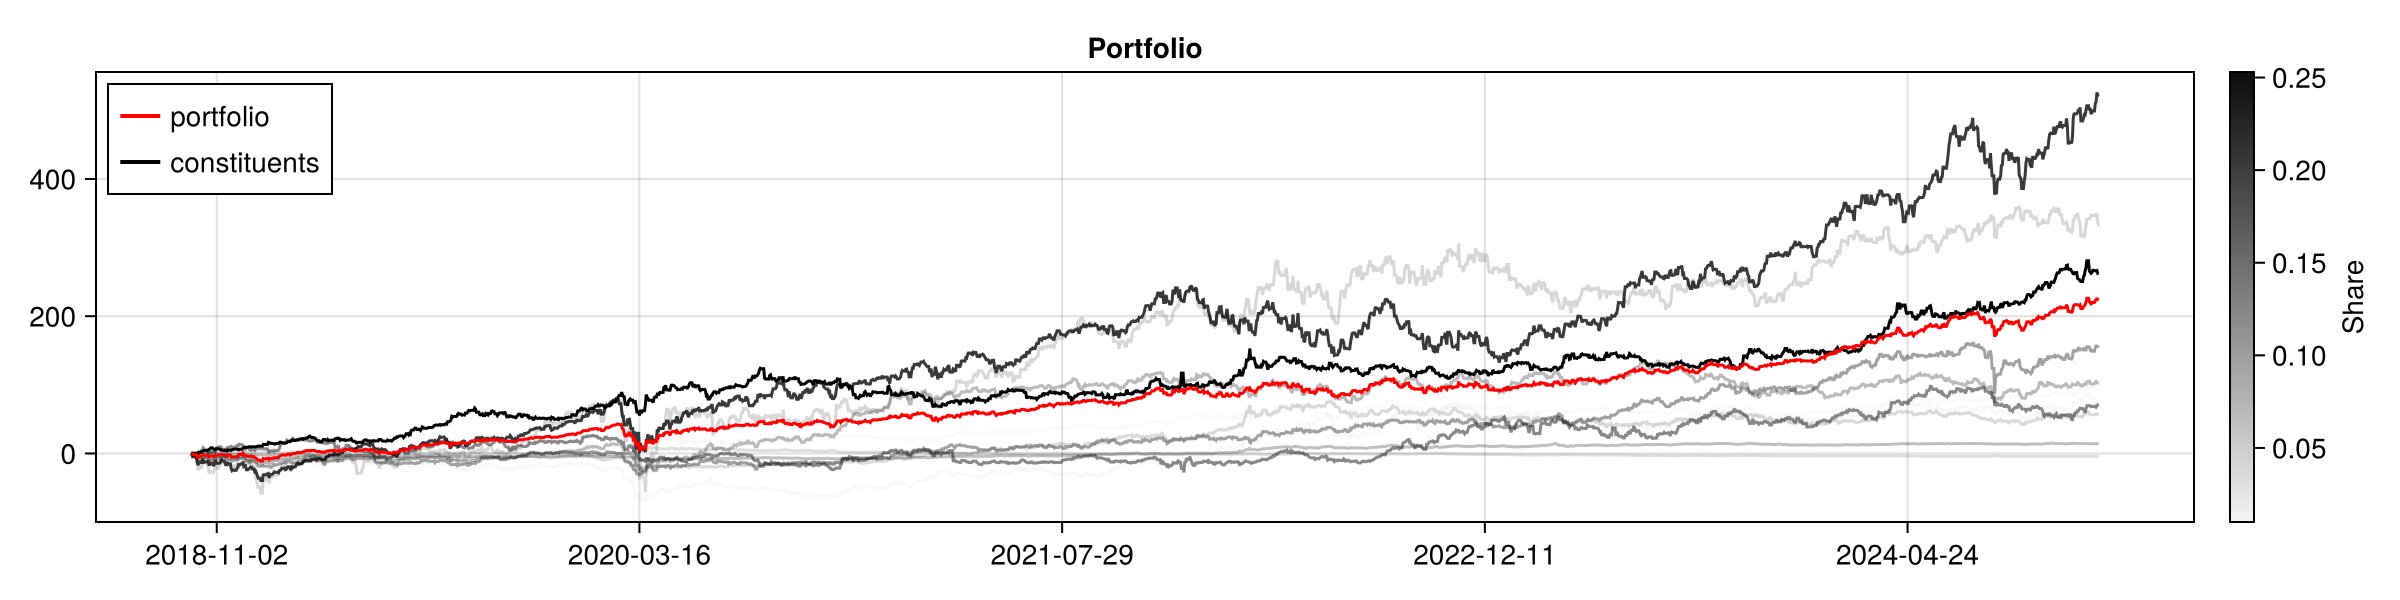

In [8]:
w_opt_round=round.(w_opt; digits=3);
share_color=(w_opt_round.-findmin(w_opt_round)[1])./(findmax(w_opt_round)[1]-findmin(w_opt_round)[1])

tickers_in_portfolio=DO.isin
DC_nrm=dropmissing(DC[:, ["date",tickers_in_portfolio...]])
mapcols!(x->x.-x[1].+100,DC_nrm; cols=Not("date"))

portfolio_value=sum(Matrix(reshape(w_opt_round,1,length(w_opt_round)).*DC_nrm[!,Not("date")]); dims=2)[:]

fig=Figure(;size=(1200,300))
ax=Axis(fig[1,1], title="Portfolio")

# Plot constituents first
constituent_line = nothing
for tk in names(DC_nrm)[2:end][w_opt_round.>1e-10]
    tk_ind=findfirst(x->x==tk,names(DC_nrm)[2:end])
    constituent_line = lines!(ax,DC_nrm[!,"date"], DC_nrm[!,tk].-100; color=(:black,share_color[tk_ind]))
end

# Plot portfolio
portfolio_line = lines!(ax,DC_nrm[!,"date"], portfolio_value.-100; color=:red)

# Add legend with explicit colors
axislegend(ax, [LineElement(linewidth=2, color=:red), LineElement(linewidth=2, color=:black)], ["portfolio", "constituents"], position=:lt)

# Add colorbar for shares
cbar = Colorbar(fig[1, 2], limits=(minimum(w_opt_round), maximum(w_opt_round)),
                colormap=Reverse(:grays), label="Share")

fig